**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [50]:
# import packages
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt 
from types import SimpleNamespace

# plot layout
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

First, insert the constraint such that the problem becomes

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left((\kappa+(1-\tau)wL)^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}.\\
\end{align*}
$$

Now, the only constraint is that $L \in [0,24]$.

Second, define parameters and the utility function.

In [399]:
# a. namespace for parameters
par = SimpleNamespace()

# b. baseline parameters
par.G = np.nan
par.v = 1/(2*16**2)
par.alpha = 0.5
par.kappa = 1.0
par.tau = 0.30
par.w = 1.0

In [400]:
def f_utility(L,**kwargs): 
    
    # update parameters if different from baseline
    for key, value in kwargs.items():
        setattr(par,key,value)

    disutility = par.v * (L**2)/2
    utility = np.log((par.kappa + (1-par.tau) * par.w * L)**par.alpha * par.G**(1-par.alpha))  
    
    return - (utility - disutility) # negative since we are maximizing

Then, given $G \in \{1.0, 2.0\}$, search over $L \in [0, 24]$, and pick the $L^*$ that yields the highest utility.

Since the choice set is continouos, I use ```scipy.optimize.minimize```.

In [402]:
# a. government spending
Gs = [1.0,2.0]

# b. list for solutions
sol = []

# c. loop over G and save solutions
for G in Gs:
    
    # c1. update G
    par.G = G
    # c2. find optimal labor supply
    res = scipy.optimize.minimize(f_utility, x0=10, method="Nelder-Mead", bounds=[(0,24)]) 
    # c3. save solution
    sol.append(res.x) 

Next, define a function that computes the analytical solution, $L^*$.

In [403]:
def Lstar(**kwargs):
    
    # a. update parameters if different from baseline
    for key, value in kwargs.items():
        setattr(par,key,value)

    # b. compute analytical Lstar
    num = -par.kappa + np.sqrt(par.kappa**2 + 4 * par.alpha/par.v * ((1-par.tau)*par.w)**2)
    denum = 2 * (1-par.tau) * par.w

    return num/denum

Now, print numerical solutions and verify that they align with analytical solution.

It is not surprising that the numerical solution does not vary with $G$ as the analytical solution is independent of $G$.

In [404]:
# numerical solution
print(f'Numerical Lstar for G = 1.0: '+str(sol[0]))
print(f'Numerical Lstar for G = 2.0: '+str(sol[1]))

# analytical solution
print(f'Analytical Lstar: '+str(Lstar(w=1.0)))

Numerical Lstar for G = 1.0: [15.30163574]
Numerical Lstar for G = 2.0: [15.30163574]
Analytical Lstar: 15.30165022719559


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

Loop over a grid of wages, $w$, and save the analytical solution for $L^*(\tilde{w})$ for each $w$ in a list.

In [384]:
# a. define a grid of wages
grid_w = np.linspace(1, 10, 46)

# b. list of solutions for each w
sols = []

# c. loop over grid and save solution to list
for w in grid_w:
    sols.append(Lstar(w=w))

Then, plot the solutions. 

The results indicate that the optimal labor supply, $L^*(\tilde{w})$, depends positively on the wage, $w$.

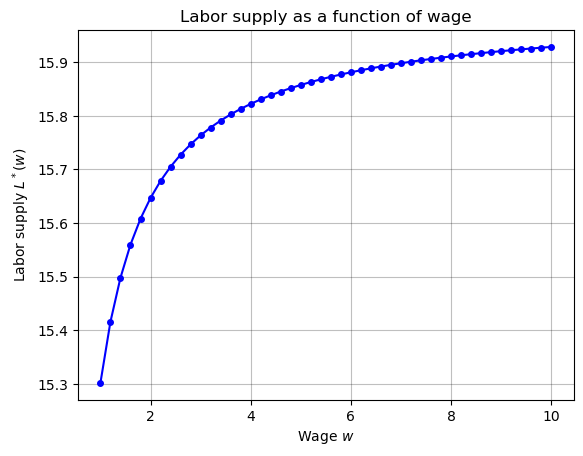

In [385]:
plt.plot(grid_w, sols, 'o', color='blue', markersize=4)
plt.plot(grid_w, sols, '-', color='blue')

plt.title('Labor supply as a function of wage')
plt.ylabel('Labor supply $L^*(w)$')
plt.xlabel('Wage $w$')
plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


First, define a function that computes the government spending for a given labor supply, $L$.

In [405]:
def G_spending(L,**kwargs):
        
    # update parameters if different from baseline
    for key, value in kwargs.items():
        setattr(par,key,value)

    return par.tau * par.w * L

Then, loop over a grid of $\tau$ and

1) Find optimal labor supply, $L^*(\tilde{w})$
2) Compute the government spending, $G$
3) Compute the resulting worker utility, $U$

In [406]:
# a. define a grid of tau
grid_tau = np.linspace(0.03, 0.97, 20)

# b. list of solutions for each tau
sols_L = []
sols_G = []
sols_U = []

# c. loop over grid of tau and save solution to list
for tau in grid_tau:

    # c1. optimal labor supply
    Lstar_ = Lstar(tau=tau)
    # c2. resulting government
    par.G = G_spending(Lstar_, tau=tau)
    # c3. save to lists
    sols_G.append(par.G)
    sols_L.append(Lstar_)
    sols_U.append(-f_utility(Lstar_, tau=tau))

Finally, plot the results.

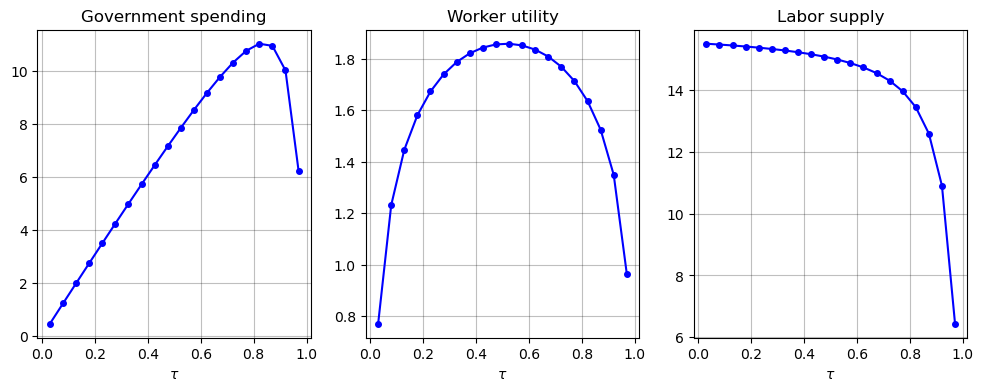

In [407]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.set_title('Government spending')
ax2.set_title('Worker utility')
ax3.set_title('Labor supply')

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\tau$')
ax3.set_xlabel(r'$\tau$')

ax1.plot(grid_tau, sols_G, color='blue')
ax3.plot(grid_tau, sols_L, color='blue')
ax2.plot(grid_tau, sols_U, color='blue')

ax1.plot(grid_tau, sols_G, 'o', color='blue', markersize=4)
ax3.plot(grid_tau, sols_L, 'o', color='blue', markersize=4)
ax2.plot(grid_tau, sols_U, 'o', color='blue', markersize=4)

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

First, define an objective function that given a value for $\tau$

1) Finds optimal labor supply, $L^*(\tilde{w})$
2) Computes the government spending, $G$
3) Returns the resulting worker utility, $U$

Then, I use ```scipy.optimize.minimize``` to find the tax rate, $\tau^*$, that maximizes worker utility.

In [408]:
# a. define utility function for varying tau
def f_obj(tau):
    Lstar_ = Lstar(tau=tau)
    G = G_spending(Lstar_, tau=tau)
    U = f_utility(Lstar_, tau=tau, G=G)
    return U

# b. call optimizer
opt_tau = scipy.optimize.minimize(f_obj, x0=0.2, method='Nelder-Mead', bounds=[(0,1)])

# c. calculate L and G
L_opt_tau = Lstar(tau=opt_tau.x)
G_opt_tau = G_spending(L_opt_tau,tau=opt_tau.x)

# d. print results 
print(f'Optimal tax rate: '+str(opt_tau.x))
print(f'Labor supply at optimal tau: '+str(L_opt_tau))
print(f'Worker utility at optimal tau: '+str(-opt_tau.fun))
print(f'Government spending at optimal tau: '+str(G_opt_tau))

Optimal tax rate: [0.51453125]
Labor supply at optimal tau: [15.0031821]
Worker utility at optimal tau: 1.8591992509322721
Government spending at optimal tau: [7.71960604]


A plot of the optimal tax rate:

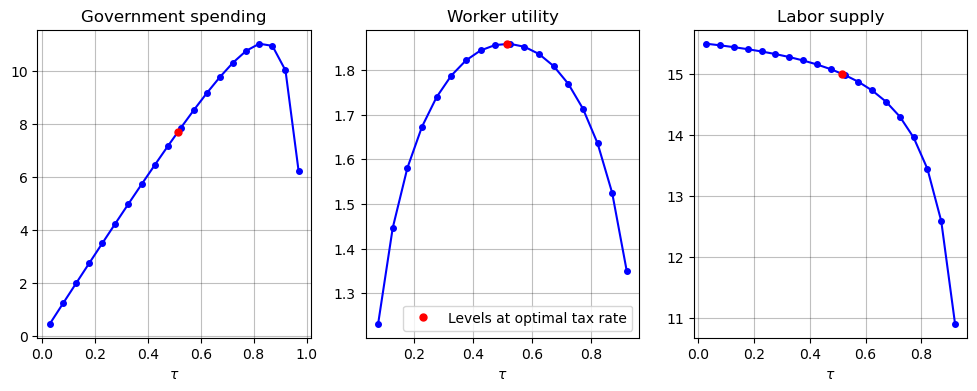

In [409]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.set_title('Government spending')
ax2.set_title('Worker utility')
ax3.set_title('Labor supply')

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\tau$')
ax3.set_xlabel(r'$\tau$')

ax1.plot(grid_tau, sols_G, color='blue')
ax3.plot(grid_tau[:-1], sols_L[:-1], color='blue')
ax2.plot(grid_tau[1:-1], sols_U[1:-1], color='blue')

ax1.plot(grid_tau, sols_G, 'o', color='blue', markersize=4)
ax3.plot(grid_tau[:-1], sols_L[:-1], 'o', color='blue', markersize=4)
ax2.plot(grid_tau[1:-1], sols_U[1:-1], 'o', color='blue', markersize=4)

ax1.plot(opt_tau.x, G_opt_tau, 'o', color='red', markersize=5)
ax3.plot(opt_tau.x, L_opt_tau, 'o', color='red', markersize=5)
ax2.plot(opt_tau.x, -opt_tau.fun, 'o', color='red', markersize=5, label='Levels at optimal tax rate')

ax2.legend()

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

First, insert the constraint such that the problem can be written as

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha (\kappa+(1-\tau)wL)^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon}
\end{align*}    
$$

Second, define parameters.

In [410]:
# a. define new baseline parameters
par.epsilon = 1.0
par.sigma = 1.001
par.rho = 1.001

# b. reset other parameters
par.v = 1/(2*16**2)
par.alpha = 0.5
par.kappa = 1.0
par.w = 1.0
par.G = 10

# c. use optimal tau
par.tau = opt_tau.x

Third, define a utility function that returns utility for given labor supply, $L$.

As a starting point, treat $G$ as a given parameter and let $\tau = \tau^*$ from question 4.

In [411]:
def f_utility_general(L,**kwargs): 
    
    # a. update parameters if different from baseline
    for key, value in kwargs.items():
        setattr(par,key,value)

    # b. compute utility
    exponent = ((par.sigma - 1)/par.sigma)
    term1 = (1-par.alpha) * par.G**exponent
    term2 = par.alpha * (par.kappa + (1-par.tau) * par.w * L)**exponent
    utility = (((term1 + term2)**(1/exponent))**(1-par.rho) - 1)/(1 - par.rho)
    disutility = par.v * (L**(1+par.epsilon)/(1+par.epsilon))
    
    return - (utility - disutility) # negative since we are maximizing

Then, define an objective function that 

1) Takes government spending, $G$, as input 
2) Finds optimal labor supply given $G$
3) Returns $G - \tau w L^*(\tilde{w},G)$

In [412]:
def f_obj(G):

    # a. update G
    par.G = G
    # b. find optimal labor supply given G
    Lstar = scipy.optimize.minimize(f_utility_general, x0=10, method="Nelder-Mead", bounds=[(0,24)])
    # c. return function value
    return par.G - par.tau * par.w * Lstar.x

Find the root of $G - \tau w L^*(\tilde{w},G)$ using ```scipy.optimize.root_scalar```.

In [413]:
res = scipy.optimize.root_scalar(f_obj,bracket=[0,20],method='brentq')
print(res)

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 7.711216783523576


Thus, $G = 7.71$ satisfies $G = \tau w L^*(\tilde{w},G)$.

Check the root graphically:

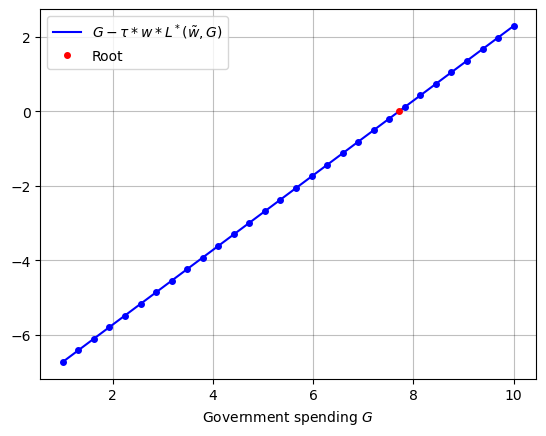

In [414]:
# a. initialize
f_val = []
Lstars = []
grid_G = np.linspace(1,10,30)

# b. loop over grid of G
for G in grid_G:
    
    # b1. update G
    par.G = G
    # b2. find optimal labor supply given G
    Lstar = scipy.optimize.minimize(f_utility_general, x0=10, method="Nelder-Mead", bounds=[(0,24)])
    # b3. evaluate function and save 
    f_val.append(par.G - par.tau * par.w * Lstar.x)

# c. plot the function and the root
label = r'$G - \tau * w * L^*(\tilde{w},G)$'
plt.plot(grid_G, f_val, 'o', color='blue', markersize=4)
plt.plot(grid_G, f_val, '-', color='blue', label = label)
plt.plot(res.root, 0, 'o', color='red', markersize=4, label = 'Root')
plt.xlabel('Government spending $G$')
plt.legend()
plt.show()

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

Define an objective function that given a tax rate $\tau$

1) Finds the $G$ and $L^*$ such that $G = \tau w L^*(\tilde{w},G)$
2) Returns the resulting worker utility

I re-use code from question 5 to do step 1.

Then, I use ```scipy.optimize.root_scalar``` to find the tax rate that maximizes worker utility, $\tau^*$.

In [415]:
def f_obj_extend(tau):

    # a. update tau
    par.tau = tau
    # b. find G that solves 
    res = scipy.optimize.root_scalar(f_obj,bracket=[0,20],method='brentq')
    # c. update G
    par.G = res.root
    # d. optimal labor supply
    Lstar = par.G/(par.tau * par.w)
    # e. return worker utility
    return f_utility_general(Lstar)

In [416]:
opt_tau = scipy.optimize.minimize(f_obj_extend, x0=0.5, method="Nelder-Mead", bounds=[(0,1)])
L_opt_tau = par.G/(par.tau * par.w)
G_opt_tau = par.G

print(f'Optimal tax rate: '+str(opt_tau.x))
print(f'Labor supply at optimal tau: '+str(L_opt_tau))
print(f'Worker utility at optimal tau: '+str(-opt_tau.fun))
print(f'Government spending at optimal tau: '+str(G_opt_tau))

Optimal tax rate: [0.51445312]
Labor supply at optimal tau: [14.98724365]
Worker utility at optimal tau: 1.8564990973867865
Government spending at optimal tau: 7.708770734071731


Note that these results are almost identical to the ones derived earlier using the previous model.

This is because the current model is a generalization of the previous model.

For $\sigma \rightarrow 1$, $\rho \rightarrow 1$, and $\epsilon = 1$ the models are similar.

We can check the results graphically:

In [417]:
# a. define a grid of tau
grid_tau = np.linspace(0.03, 0.97, 20)

# b. list of solutions for each tau
sols_L = []
sols_G = []
sols_U = []

# c. loop over grid and save solution to list
for tau in grid_tau:
    
    # c1. update tau
    par.tau = tau

    # c2. find G that solves 
    res = scipy.optimize.root_scalar(f_obj,bracket=[0,20],method='brentq')

    # c3. update G
    par.G = res.root

    # c4. optimal labor supply
    Lstar = par.G/(par.tau * par.w)

    # c5. save solutions
    sols_G.append(par.G)
    sols_L.append(Lstar)
    sols_U.append(-f_utility_general(Lstar))

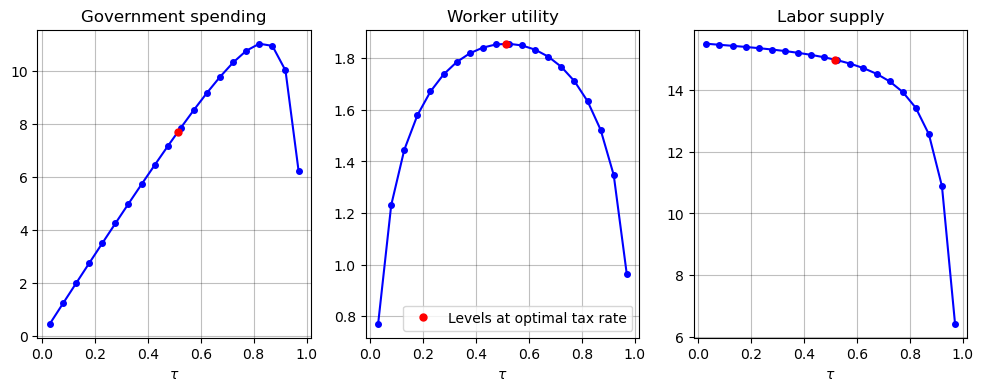

In [418]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.set_title('Government spending')
ax2.set_title('Worker utility')
ax3.set_title('Labor supply')

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\tau$')
ax3.set_xlabel(r'$\tau$')

ax1.plot(grid_tau, sols_G, color='blue')
ax3.plot(grid_tau, sols_L, color='blue')
ax2.plot(grid_tau, sols_U, color='blue')

ax1.plot(grid_tau, sols_G, 'o', color='blue', markersize=4)
ax3.plot(grid_tau, sols_L, 'o', color='blue', markersize=4)
ax2.plot(grid_tau, sols_U, 'o', color='blue', markersize=4)

ax1.plot(opt_tau.x, G_opt_tau, 'o', color='red', markersize=5)
ax3.plot(opt_tau.x, L_opt_tau, 'o', color='red', markersize=5)
ax2.plot(opt_tau.x, -opt_tau.fun, 'o', color='red', markersize=5, label='Levels at optimal tax rate')

ax2.legend()

However, if $\sigma = 1.5$ and $\rho = 1.5$, we get different results. Let's reset everything and define new $\sigma$ and $\rho$.

In [419]:
# a. define new baseline parameters
par.epsilon = 1.0
par.sigma = 1.5 # new value
par.rho = 1.5 # new value

# b. reset other parameters
par.v = 1/(2*16**2)
par.alpha = 0.5
par.kappa = 1.0
par.w = 1.0
par.G = 10

# c. use optimal tau
par.tau = opt_tau.x

Find new optimal tax rate, $\tau^*$, of new parameters.

In [420]:
opt_tau = scipy.optimize.minimize(f_obj_extend, x0=0.5, method="Nelder-Mead", bounds=[(0,1)])
L_opt_tau = par.G/(par.tau * par.w)
G_opt_tau = par.G

print(f'Optimal tax rate: '+str(opt_tau.x))
print(f'Labor supply at optimal tau: '+str(L_opt_tau))
print(f'Worker utility at optimal tau: '+str(-opt_tau.fun))
print(f'Government spending at optimal tau: '+str(G_opt_tau))

Optimal tax rate: [0.4609375]
Labor supply at optimal tau: [9.89208984]
Worker utility at optimal tau: 1.0435959924699658
Government spending at optimal tau: 4.560601186752352


Now, $\tau^*$ is lower.

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

First, define baseline parameters and profit function as well as function that returns analytical solution for $\ell_t^*$.

In [573]:
# baseline parameters
par.eta = 0.5
par.w = 1.0
par.kappa = np.nan

In [574]:
# profit function
def profits(l):
     return - (par.kappa * l**(1-par.eta) - par.w * l) # negative since we are maximizing

# analytical solution to l
def lstar(kappa):
     return (((1-par.eta) * kappa)**(1/par.eta))

Then, use ```scipy.optimize.minimize``` to find the optimal $\ell^*_t$ and compare with analytical solution.

In [575]:
# a. initialize
kappas = [1.0, 2.0]
sols_num = []
sols_an = []

# b. loop over kappas
for kappa in kappas:

    # b1. updata kappa
    par.kappa = kappa
    # b2. find optimal l numerically
    lstar_num = scipy.optimize.minimize(profits, x0=1, method='Nelder-Mead', bounds=[(0,np.inf)])
    # b3. find optimal l analytically
    lstar_an = lstar(kappa)
    # b4. save to list
    sols_an.append(lstar_an)
    sols_num.append(lstar_num.x)

# c. print solutions and compare with analytical solution
print(f'Numerical solution for kappa = 1: '+str(sols_num[0]))
print(f'Numerical solution for kappa = 2: '+str(sols_num[1]))
print(f'Analytical solution for kappa = 1: '+str(sols_an[0]))
print(f'Analytical solution for kappa = 2: '+str(sols_an[1]))

Numerical solution for kappa = 1: [0.25]
Numerical solution for kappa = 2: [1.]
Analytical solution for kappa = 1: 0.25
Analytical solution for kappa = 2: 1.0


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

First, define baseline parameters.

In [576]:
par.T = 121 # first period is t = -1
par.K = np.nan # set later
par.sigma = 0.1
par.iota = 0.01
par.rho = 0.9
par.R = 1.01**(1/12)

Second, create a random grid of $\epsilon$. The grid is constructed such that

- Each row corresponds to a random shock series, $k$
- Each column corresponds to a specific month, $t$

Then, use the grid of $\epsilon$ to construct a grid of $\kappa$ that follows the given AR(1) process.

In [594]:
def setup():

    # a. set seed
    np.random.seed(2023)
    
    # b. random grid of epsilons
    grid_epsilon = np.random.normal(-0.5 * par.sigma**2, # mean
                                    np.sqrt(par.sigma),  # variance
                                    (par.K, par.T))      # rows and columns

    # c. grid of kappa

    # c1. initialize
    grid_kappa = np.zeros((par.K, par.T)) + 1e-8
    grid_kappa[:,0] = 1 # since kappa_(-1) = 1

    # c2. AR(1) process 
    kappa = lambda epsilon,kappa_lag: np.exp(par.rho * np.log(kappa_lag) + epsilon)

    # c3. construct grid of kappa
    for t in range(1,par.T-1):
        epsilon = grid_epsilon[:,t]
        kappa_lag = grid_kappa[:,t-1]
        grid_kappa[:,t] = kappa(epsilon,kappa_lag)
    
    return grid_kappa

To compute the ex ante expected value, $H$, define three functions as below.

In [578]:
# a. function to discount profit matrix
def discount(profits):
    for t in range(par.T-1):
        profits[:,t] = profits[:,t]*par.R**(-t)
    return profits

# b. function to compute iota matrix
def iota(l):
    iota = par.iota * np.ones((par.K, par.T))
    for t in range(1,par.T-1):
        for k in range(par.K-1):
            if l[k,t]-l[k,t-1] == 0:
                iota[k,t] = 0
    return iota

# c. function to compute ex ante value
def value_ex_ante(grid_kappa,policy):
    
    # c1. calculate production input, l 
    l = policy(grid_kappa)
    l[:,0] = 1e-8 # since l_(-1) = 0
    
    # c2. calculate profits
    profits = grid_kappa * l**(1-par.eta) - par.w * l - iota(l)
    
    # c3. disregard t = -1
    profits = profits[:,1:]
    
    # c4. discount profits
    discounted_profits = discount(profits)
    
    # c5. calculate ex ante value as the mean
    value_ex_ante = (1/par.K) * np.sum(discounted_profits)

    return value_ex_ante

To check how large $K$ must be to acheive accurate approximations of $H$, loop over different values for $K$ and compute $H$ for each $K$. Then, plot the results.

In [579]:
values = []
Ks = []

# loop over differnt k
for k in range(100,1000):
    
    # a. update par.K
    par.K = k
    # b. get grid_kappa
    grid_kappa = setup()
    # c. compute ex ante value
    value = value_ex_ante(grid_kappa,lstar)
    # d. save value to list
    values.append(value)
    Ks.append(k)

Based on the plot below, it seems that $K > 600$ is needed. I will set $K = 1000$ from now on.

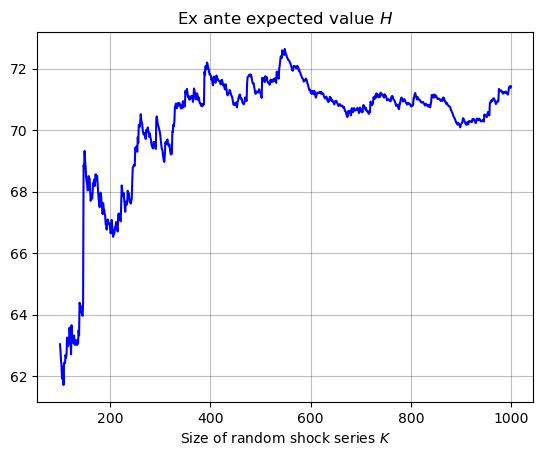

In [580]:
plt.plot(Ks, values, '-', color='blue')
plt.xlabel('Size of random shock series $K$')
plt.title('Ex ante expected value $H$')
plt.show()

In [581]:
par.K = 1000
grid_kappa = setup()
value = value_ex_ante(grid_kappa,lstar)
print(f'Estimated ex ante expected value based on K = 1000: '+str(value))

Estimated ex ante expected value based on K = 1000: 71.3987958600368


Thus, $\hat{H} = 71.40$.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

First, define new parameter, $\Delta$.

In [582]:
par.delta = 0.05

Second, define a new policy function that for a given $\kappa$ computes the $\ell$ as stated above.

In [583]:
def lstar_new(grid_kappa):

     # a. start with lstar        
     l = lstar(grid_kappa)
     l[:,0] = 1e-8 # since l_(-1) = 0
     
     # b. check if change in l is > delta. Otherwise, keep old l
     for t in range(1,par.T-1):
        for k in range(par.K-1):
            if abs(l[k,t]-l[k,t-1]) <= par.delta:
                l[k,t] = l[k,t-1]

     return l

Compute new approximation of ex ante expected value, $H$.

In [584]:
grid_kappa = setup()
value = value_ex_ante(grid_kappa,lstar_new)
print(f'Estimated ex ante expected value from new policy: '+str(value))

Estimated ex ante expected value from new policy: 71.69778749419356


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

Define an objective function that given a $\Delta$ returns $\hat{H}$.

In [585]:
def f_obj(delta):

    # a. update delta
    par.delta = delta
    # b. compute kappa
    grid_kappa = setup()
    # c. compute estimated ex ante expected value, H
    value = value_ex_ante(grid_kappa,lstar_new)

    return - value # negative since we are maximizing

Use ```scipy.optimize.minimize``` to maximize $\hat{H}$ with $\Delta$ as argument.

In [586]:
res = scipy.optimize.minimize(f_obj, x0=0.05, method='Nelder-Mead', bounds=[(0,np.inf)])
print(f'Estimated ex ante expected value at optimal delta: '+str(-res.fun))
print(f'Optimal delta: '+str(res.x))

Estimated ex ante expected value at optimal delta: 71.70062085784664
Optimal delta: [0.05710938]


Illustration of the optimal value:

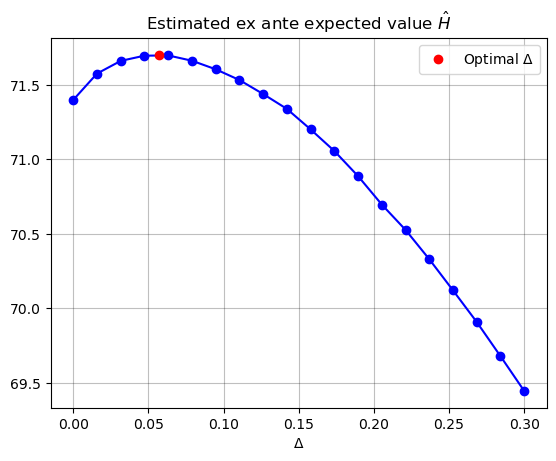

In [587]:
values = []
grid_delta = np.linspace(0,0.3,20)

# a. loop over grid of delta
for delta in grid_delta:

    # a1. update delta
    par.delta = delta
    # a2. compute kappa
    grid_kappa = setup()
    # a3. compute estimated ex ante expected value, H
    value = value_ex_ante(grid_kappa,lstar_new)
    # a4. save to list
    values.append(value)

# b. plot
plt.plot(grid_delta, values, 'o', color='blue')
plt.plot(grid_delta, values, '-', color='blue')
plt.plot(res.x, -res.fun, 'o', color='red', label=r'Optimal $\Delta$')
plt.title(r'Estimated ex ante expected value $\hat{H}$')
plt.xlabel(r'$\Delta$')
plt.legend()
plt.show()


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [599]:
par.lambdaa = 0.1

In [600]:
def lstar_forward(grid_kappa):
    
    exp_kappa_next = np.exp(np.log(grid_kappa) - 0.5 * par.sigma**2)
    num = (exp_kappa_next - par.R * grid_kappa) * (1 - par.eta)
    denum = w * (1 - par.R)
    
    return (num/denum)**(1/par.eta)

In [601]:
def lstar_alt(grid_kappa):

    # a. start with lstar        
    lstar_static = lstar(grid_kappa)
    lstar_for = lstar_forward(grid_kappa)
    l = par.lambdaa * lstar_for + (1 - par.lambdaa) * lstar_static

    return l

In [602]:
grid_kappa = setup()
value = value_ex_ante(grid_kappa,lstar_alt)
print(f'Estimated ex ante expected value based on K = 1000: '+str(value))

Estimated ex ante expected value based on K = 1000: 71.3507169979062


In [604]:
def f_obj(lambdaa):

    # a. update delta
    par.lambdaa = lambdaa
    # b. compute kappa
    grid_kappa = setup()
    # c. compute estimated ex ante expected value, H
    value = value_ex_ante(grid_kappa,lstar_alt)

    return - value # negative since we are maximizing

In [605]:
res = scipy.optimize.minimize(f_obj, x0=0.05, method='Nelder-Mead', bounds=[(0,np.inf)])
print(f'Estimated ex ante expected value at optimal delta: '+str(-res.fun))
print(f'Optimal delta: '+str(res.x))

Estimated ex ante expected value at optimal delta: 71.3987958600368
Optimal delta: [0.]


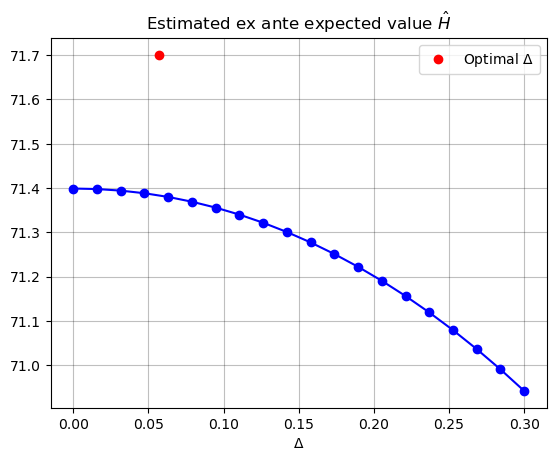

In [603]:
values = []
grid_lambda = np.linspace(0,0.3,20)

# a. loop over grid of delta
for lambdaa in grid_lambda:

    # a1. update delta
    par.lambdaa = lambdaa
    # a2. compute kappa
    grid_kappa = setup()
    # a3. compute estimated ex ante expected value, H
    value = value_ex_ante(grid_kappa,lstar_alt)
    # a4. save to list
    values.append(value)

# b. plot
plt.plot(grid_delta, values, 'o', color='blue')
plt.plot(grid_delta, values, '-', color='blue')
plt.plot(res.x, -res.fun, 'o', color='red', label=r'Optimal $\Delta$')
plt.title(r'Estimated ex ante expected value $\hat{H}$')
plt.xlabel(r'$\Delta$')
plt.legend()
plt.show()

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [13]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [14]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [15]:
# write your code here